# In-context learning few-shot experiments

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [5]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from typing import Dict, List
from matplotlib import cm, colors

from configs.config import get_experiment_config, get_model_config
from src.training_init import TrainingInitializer
from src.train import _compute_loss
from src.models.auxiliary_models import LeastSquaresSequenceSolver
from src.util.in_context_learning.icl_eval import ICLEvaluator
from src.data.icl.icl_single import ICLSingleGenerator
from src.data.icl.icl_multi import ICLMultiGenerator
from src.data.token_finetuning.eos_finetuner import EOSFineTuner
from src.data.token_finetuning.prefix_finetuner import PrefixFineTuner

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False

path_chebyshev = 'experiments/auxmodel_params/cheb_params.pkl'

path_model_fully_sm = 'experiment_results/icl/model_sm_7l_fullfledged.pkl'
path_model_fully_mesa = 'experiment_results/icl/model_mesa_fullfledged.pkl'

path_eos_softmax = 'experiment_results/icl/eos_softmax.pkl'
path_eos_mesa = 'experiment_results/icl/eos_mesa.pkl'
path_prefix_softmax = 'experiment_results/icl/prefix_softmax.pkl'
path_prefix_mesa = 'experiment_results/icl/prefix_mesa.pkl'

path_softmax_result_single = 'experiment_results/icl/softmax_result_dict_single.pkl'
path_softmax_result_multi = 'experiment_results/icl/softmax_result_dict_multi.pkl'

path_mesa_result_single = 'experiment_results/icl/mesa_result_dict_single.pkl'
path_mesa_result_multi = 'experiment_results/icl/mesa_result_dict_multi.pkl'

print(f'Running on Devices: {gpus},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


In [7]:
models_full = {'full_seven_sm': 'fully_obs_full_fledged_transformer.6.4.40.224.20.True.False.False.False.0.False.False.0.False.False.False.False',
               'full_mesa':            'fully_obs_full_fledged_mesa.1.4.40.224.20.True.False.False.False.0.False.True.1.False.False.False.False'}

## Train models on linear dynamical systems and evaluate on few-shot tasks:

In [8]:
exp_config_sensitivity = get_experiment_config(experiment='icl', seeds=[1, 11, 111, 1111, 11111])
(model, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_full['full_seven_sm']), 
                                                                       experiment_config=exp_config_sensitivity).run()
training_seed = 68
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
if rerun_models:
    state_tf, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(150):
        state_tf, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                state=state_tf,
                                                                rng=train_rng,
                                                                test_rng=test_rng,
                                                                num_batches_train=100,
                                                                interpolate=False)
    if store_results:
        print(f'Storing model at {path_model_fully_sm}')
        a = {'params' : state_tf.params}
        with open(path_model_fully_sm, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fully_sm, 'rb') as handle:
        a = pkl.load(handle)
    state_tf = train_state.TrainState.create(apply_fn=model.apply, params=a['params'], tx=optimizer)

model:  fully_obs_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  40  seq_len:  224  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0


In [9]:
icl_single_generator = ICLSingleGenerator(seq_len=225, data_dim=10, range=1, noise=0.01)

# EOS Finetuning:
eos_finetuner = EOSFineTuner(model_tf=model,
                             state_tf=state_tf,
                             data_generator=icl_single_generator,
                             train_batch_size=64,
                             finetune_steps=5000,
                             eos_dim=10,
                             use_prompt=False,
                             prompt=None)
if rerun_models:
    eos_token = eos_finetuner.finetune(rng=jax.random.PRNGKey(42),
                                       finetune_lr=1e-3)
    if store_results:
        print(f'Storing eos token at {path_eos_softmax}.')
        a = {'eos_token' : eos_token}
        with open(path_eos_softmax, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_eos_softmax, 'rb') as handle:
        a = pkl.load(handle)
    eos_token = a['eos_token']

# Prefix Finetuning:
prefix_finetuner = PrefixFineTuner(model_tf=model,
                                   state_tf=state_tf,
                                   data_generator=icl_single_generator,
                                   train_batch_size=128,
                                   finetune_steps=5000,
                                   eos_token=eos_token,
                                   prefix_dims=(20,10))
if rerun_models:
    prefix = prefix_finetuner.finetune(rng=jax.random.PRNGKey(42),
                                       finetune_lr=1e-3)
    if store_results:
        print(f'Storing prefix at {path_prefix_softmax}')
        a = {'prefix' : prefix}
        with open(path_prefix_softmax, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_prefix_softmax, 'rb') as handle:
        a = pkl.load(handle)
    prefix = a['prefix']

In [10]:
lsq_solver = LeastSquaresSequenceSolver(approximator=None,
                                        seq_len=224,
                                        apx_steps=6,
                                        lamb=0.001)

icl_multi_generator = ICLMultiGenerator(seq_len_task1=81,
                                        seq_len_task2=147,
                                        data_dim=10,
                                        range=1,
                                        noise=0.01)

if rerun_analyses:
    single_res = ICLEvaluator(experiment_config=exp_config_sensitivity,
                                        model_tf=model,
                                        state_tf=state_tf,
                                        lsq_model=lsq_solver,
                                        data_generator_single=icl_single_generator,
                                        data_generator_multi=icl_multi_generator,
                                        prompt=prefix,
                                        eos=eos_token).run_single_task_icl()
    
    if store_results:
        print(f'Storing results at {path_softmax_result_single}')
        with open(path_softmax_result_single, 'wb') as handle:
            pkl.dump(single_res, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_softmax_result_single, 'rb') as handle:
        single_res = pkl.load(handle)

In [11]:
if rerun_analyses:
    multi_res = ICLEvaluator(experiment_config=exp_config_sensitivity,
                                        model_tf=model,
                                        state_tf=state_tf,
                                        lsq_model=lsq_solver,
                                        data_generator_single=icl_single_generator,
                                        data_generator_multi=icl_multi_generator,
                                        prompt=prefix,
                                        eos=eos_token).run_two_task_icl()
    if store_results:
        print(f'Storing results at {path_softmax_result_multi}')
        with open(path_softmax_result_multi, 'wb') as handle:
            pkl.dump(multi_res, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_softmax_result_multi, 'rb') as handle:
        multi_res = pkl.load(handle)

## Visualize Results:

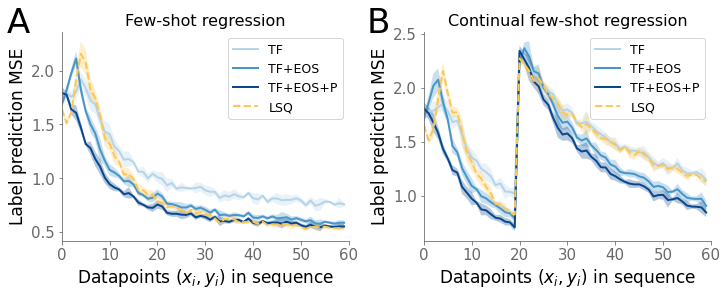

In [12]:
#@title plot
from typing import Dict, List, Tuple
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter

legend_fontsize = 'small'

def subplot_single(ax,
                   single_dict: Dict[str, any],
                   cols: List,
                   max_len: int):
    y_preds_mean = single_dict['eos_preds_mean'][:max_len]
    y_preds_std = single_dict['eos_preds_std'][:max_len]
    y_preds_no_eos_mean = single_dict['base_preds_mean'][:max_len]
    y_preds_no_eos_std = single_dict['base_preds_std'][:max_len]
    y_preds_prefix_mean = single_dict['prompt_eos_preds_mean'][:max_len]
    y_preds_prefix_std = single_dict['prompt_eos_preds_std'][:max_len]
    y_preds_lsq_mean = single_dict['lsq_preds_mean'][:max_len]
    y_preds_lsq_std = single_dict['lsq_preds_std'][:max_len]

    ax.fill_between(range(len(y_preds_no_eos_mean)), (y_preds_no_eos_mean-y_preds_no_eos_std),(y_preds_no_eos_mean+y_preds_no_eos_std) ,alpha=0.3, facecolor=cols[0])
    ax.fill_between(range(len(y_preds_mean)), (y_preds_mean-y_preds_std),(y_preds_mean+y_preds_std) ,alpha=0.3, facecolor=cols[1])
    ax.fill_between(range(len(y_preds_prefix_mean)), (y_preds_prefix_mean-y_preds_prefix_std),(y_preds_prefix_mean+y_preds_prefix_std) ,alpha=0.3, facecolor=cols[2])
    ax.fill_between(range(len(y_preds_lsq_mean)), (y_preds_lsq_mean-y_preds_lsq_std),(y_preds_lsq_mean+y_preds_lsq_std) ,alpha=0.3, facecolor=cols[3])

    ax.plot(y_preds_no_eos_mean,   color=cols[0], linewidth=2, label='TF')
    ax.plot(y_preds_mean,   color=cols[1], linewidth=2, label='TF+EOS')
    ax.plot(y_preds_prefix_mean,   color=cols[2], linewidth=2, label='TF+EOS+P')
    ax.plot(y_preds_lsq_mean,   color=cols[3], linewidth=2, linestyle='dashed', label='LSQ')

    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Datapoints $(x_i, y_i)$ in sequence')
    ax.set_ylabel('Label prediction MSE')
    ax.set_xlim(0,max_len)
    ax.legend(loc=1, fontsize=legend_fontsize)

def subplot_multi(ax,
                  multi_dict: Dict[str, any],
                  cols: List,
                  max_len: int):
    y_preds_mean = multi_dict['eos_preds_mean'][:max_len]
    y_preds_std = multi_dict['eos_preds_std'][:max_len]
    y_preds_no_eos_mean = multi_dict['base_preds_mean'][:max_len]
    y_preds_no_eos_std = multi_dict['base_preds_std'][:max_len]
    y_preds_prefix_mean = multi_dict['prompt_eos_preds_mean'][:max_len]
    y_preds_prefix_std = multi_dict['prompt_eos_preds_std'][:max_len]
    y_preds_lsq_mean = multi_dict['lsq_preds_mean'][:max_len]
    y_preds_lsq_std = multi_dict['lsq_preds_std'][:max_len]

    ax.fill_between(range(len(y_preds_no_eos_mean)), (y_preds_no_eos_mean-y_preds_no_eos_std),(y_preds_no_eos_mean+y_preds_no_eos_std) ,alpha=0.3, facecolor=cols[0])
    ax.fill_between(range(len(y_preds_mean)), (y_preds_mean-y_preds_std),(y_preds_mean+y_preds_std) ,alpha=0.3, facecolor=cols[1])
    ax.fill_between(range(len(y_preds_prefix_mean)), (y_preds_prefix_mean-y_preds_prefix_std),(y_preds_prefix_mean+y_preds_prefix_std) ,alpha=0.3, facecolor=cols[2])
    ax.fill_between(range(len(y_preds_lsq_mean)), (y_preds_lsq_mean-y_preds_lsq_std),(y_preds_lsq_mean+y_preds_lsq_std) ,alpha=0.3, facecolor=cols[3])

    ax.plot(y_preds_no_eos_mean,   color=cols[0], linewidth=2, label='TF')
    ax.plot(y_preds_mean,   color=cols[1], linewidth=2, label='TF+EOS')
    ax.plot(y_preds_prefix_mean,   color=cols[2], linewidth=2, label='TF+EOS+P')
    ax.plot(y_preds_lsq_mean,   color=cols[3], linewidth=2, linestyle='dashed', label='LSQ')

    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Datapoints $(x_i, y_i)$ in sequence')
    ax.set_ylabel('Label prediction MSE')
    ax.set_xlim(0,max_len)
    ax.legend(loc=1, fontsize=legend_fontsize)

def plot_icl(single_dict: Dict[str, any],
             multi_dict: Dict[str, any],
             max_len: int):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    colormap_sm, colormap_mesa, colormap_lin = tuple([plt.get_cmap(col, 100) for col in ['Blues', 'Reds', 'Greens']])
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//8)*(k+1) for k in range(8)]]

    colormap = colormap_sm
    c_tf7_eos_prompt = subplot_col_fn(colormap)[-1]
    c_tf7_eos = subplot_col_fn(colormap)[-4]
    c_tf7_base = subplot_col_fn(colormap)[-7]
    c_lsq = plt.get_cmap('YlOrBr', 100)(36)

    cols_p1 = [c_tf7_base, c_tf7_eos, c_tf7_eos_prompt, c_lsq]

    fig, axs = plt.subplots(nrows=1,
                            ncols=2,
                            figsize=(10, 4),
                            gridspec_kw={'width_ratios': [1,1]},
                            layout='constrained')

    ################################################
    # Single Performance:
    subplot_single(ax=axs[0],
                   single_dict=single_dict,
                   cols=cols_p1,
                   max_len=max_len)

    subplot_multi(ax=axs[1],
                   multi_dict=multi_dict,
                   cols=cols_p1,
                   max_len=max_len)

    ################################################
    axs[0].set_title('Few-shot regression', fontsize=16)
    axs[1].set_title('Continual few-shot regression', fontsize=16)

    label_size = 34  # Size of the labels
    axs[0].text(-0.19, 1.12, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.20, 1.12, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')

    if store_results:
        fig.savefig('icl_softmax.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_icl(single_dict = single_res,
         multi_dict = multi_res,
         max_len = 60)